In [1]:
!which python

/mnt/netapp2/Store_uni/home/ulc/co/rpj/projects/CP-HOSfing/venv/bin/python


In [2]:
import random
import numpy as np
import pandas as pd
import polars as pl
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from concurrent.futures import ThreadPoolExecutor

sns.set(color_codes=True)
%matplotlib inline 

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)

### Functions Definitions

In [4]:
def my_show_df_shape(df):
    print("Number of examples/rows: {:,}".format(df.shape[0]))
    print("Number of features: {:,}".format(df.shape[1]))

In [5]:
def my_show_df_NaNs(df):
    nan_count = df.isna().sum()
    # nan_count = nan_count[nan_count > 0]
    nan_percentage = df.isna().mean() * 100
    # nan_percentage = nan_percentage[nan_percentage > 0]
    if nan_count.empty:
        print("No NaN values found in the dataset.")
    else:
        print("Number of examples/rows:", df.shape[0])
        print("Number of features:", df.shape[1])
        print("Features with NaNs:")
        for i in range(len(nan_count)):
            feature = nan_count.index[i]
            if nan_count[feature] > 0:
                print(f"{feature:<30} {nan_count[feature]:<10} {nan_percentage[feature]:<8.4f}%")
            else:
                print(f"{feature:<30} no NaNs")

### Dataset Load

In [6]:
import os

filenames = glob.glob(os.path.join(os.environ['STORE'], 'projects/CP-HOSfing/data/lastovicka2023/*.csv'))

print("Summary of CSV files found:")
total_files = len(filenames)
total_size = 0

for f in filenames:
    file_name = os.path.basename(f)
    try:
        size = os.path.getsize(f)
        with open(f, 'r', encoding='utf-8', errors='ignore') as file:
            num_lines = sum(1 for _ in file)
    except Exception as e:
        size = -1
        num_lines = -1
    total_size += size if size > 0 else 0
    print(f"File: {file_name:40}  Lines: {num_lines:8,}  Size: {size/1024/1024:8.2f} MB")

print(f"\nTotal number of files: {total_files}")
print(f"Total size: {total_size/1024/1024:.2f} MB")


Summary of CSV files found:
File: lastovicka_2023_passiveOSRevisited.csv    Lines:  109,664  Size:    91.83 MB

Total number of files: 1
Total size: 91.83 MB


In [7]:
# Load the entire dataset (no sampling)
lazy = pl.scan_csv(
    filenames,
    ignore_errors=True,
    truncate_ragged_lines=True,
    separator=";",
    infer_schema_length=0,
)

df = lazy.collect().to_pandas()

### Initial Exploration

In [8]:
df

,flow_ID,UA OS family,UA OS major,UA OS minor,UA OS patch,UA OS patch minor,start,end,L3 PROTO,L4 PROTO,...,tcpOptionMaximumSegmentSizeforward,tcpOptionMaximumSegmentSizebackward,tcpOptionNoOperationforward,tcpOptionNoOperationbackward,packetTotalCountforward,packetTotalCountbackward,flowDirection,flowEndReason,synAckFlag,
0,4313,Other,None,None,None,None,2020-07-16 06:44:07.608708000,2020-07-16 06:44:07.838529000,4,6,...,1460,1460,1,1,6,4,1,1,1,None
1,14343,Other,None,None,None,None,2020-07-16 06:45:47.865065000,2020-07-16 06:45:47.913409000,4,6,...,1460,1460,1,1,4,3,0,1,1,None
2,18958,Other,None,None,None,None,2020-07-16 06:46:30.471169000,2020-07-16 06:46:30.782348000,4,6,...,1460,1460,1,1,5,4,1,1,1,None
3,21937,Windows,10,None,None,None,2020-07-16 06:47:41.565111000,2020-07-16 06:47:45.742005000,4,6,...,1420,1460,1,1,12,12,1,1,1,None
4,14120,Other,None,None,None,None,2020-07-16 06:49:37.426397000,2020-07-16 06:49:37.640743000,4,6,...,1460,1460,1,1,5,3,1,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109658,182498,Other,None,None,None,None,2020-07-16 14:41:02.354069000,2020-07-16 14:41:03.524971000,4,6,...,1460,1460,1,1,27,34,0,4,1,None
109659,188382,Other,None,None,None,None,2020-07-16 14:41:05.719276000,2020-07-16 14:41:07.243672000,4,6,...,1460,1460,1,1,79,82,1,4,1,None
109660,185688,Other,None,None,None,None,2020-07-16 14:41:06.297307000,2020-07-16 14:41:09.714209000,4,6,...,1460,1460,1,1,47,53,0,4,1,None
109661,177703,Other,None,None,None,None,2020-07-16 14:41:08.558144000,2020-07-16 14:41:11.136282000,4,6,...,1460,1460,1,1,40,49,0,4,1,None


In [9]:
my_show_df_shape(df)

Number of examples/rows: 109,663
Number of features: 112


In [10]:
print(df.info())  # Get information about the dataset (e.g., column names, data types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109663 entries, 0 to 109662
Columns: 112 entries, flow_ID to 
dtypes: object(112)
memory usage: 93.7+ MB
None


In [11]:
print(df.head())  # Display the first few rows of the dataset

  flow_ID UA OS family UA OS major UA OS minor UA OS patch UA OS patch minor  \
0    4313        Other        None        None        None              None   
1   14343        Other        None        None        None              None   
2   18958        Other        None        None        None              None   
3   21937      Windows          10        None        None              None   
4   14120        Other        None        None        None              None   

                           start                            end L3 PROTO  \
0  2020-07-16 06:44:07.608708000  2020-07-16 06:44:07.838529000        4   
1  2020-07-16 06:45:47.865065000  2020-07-16 06:45:47.913409000        4   
2  2020-07-16 06:46:30.471169000  2020-07-16 06:46:30.782348000        4   
3  2020-07-16 06:47:41.565111000  2020-07-16 06:47:45.742005000        4   
4  2020-07-16 06:49:37.426397000  2020-07-16 06:49:37.640743000        4   

  L4 PROTO  ... tcpOptionMaximumSegmentSizeforward  \
0       

In [12]:
columns_list = df.columns.tolist()
print(columns_list)  # Get the list of columns in the dataset

['flow_ID', 'UA OS family', 'UA OS major', 'UA OS minor', 'UA OS patch', 'UA OS patch minor', 'start', 'end', 'L3 PROTO', 'L4 PROTO', 'BYTES A', 'PACKETS A', 'SRC IP', 'DST IP', 'TCP flags A', 'SRC port', 'DST port', 'ICMP TYPE', 'TCP SYN Size', 'TCP Win Size', 'TCP SYN TTL', 'IP ToS', 'HTTP Request Host', 'URL', 'NPM_CLIENT_NETWORK_TIME', 'NPM_SERVER_NETWORK_TIME', 'NPM_SERVER_RESPONSE_TIME', 'NPM_ROUND_TRIP_TIME', 'NPM_RESPONSE_TIMEOUTS_A', 'NPM_RESPONSE_TIMEOUTS_B', 'NPM_TCP_RETRANSMISSION_A', 'NPM_TCP_RETRANSMISSION_B', 'NPM_TCP_OUT_OF_ORDER_A', 'NPM_TCP_OUT_OF_ORDER_B', 'NPM_JITTER_DEV_A', 'NPM_JITTER_AVG_A', 'NPM_JITTER_MIN_A', 'NPM_JITTER_MAX_A', 'NPM_DELAY_DEV_A', 'NPM_DELAY_AVG_A', 'NPM_DELAY_MIN_A', 'NPM_DELAY_MAX_A', 'NPM_DELAY_HISTOGRAM_1_A', 'NPM_DELAY_HISTOGRAM_2_A', 'NPM_DELAY_HISTOGRAM_3_A', 'NPM_DELAY_HISTOGRAM_4_A', 'NPM_DELAY_HISTOGRAM_5_A', 'NPM_DELAY_HISTOGRAM_6_A', 'NPM_DELAY_HISTOGRAM_7_A', 'NPM_JITTER_DEV_B', 'NPM_JITTER_AVG_B', 'NPM_JITTER_MIN_B', 'NPM_JITTER_M

In [13]:
column_names_by_dtype = {str(dtype): columns.to_list() for dtype, columns in df.columns.groupby(df.dtypes).items()}
for dtype, columns in column_names_by_dtype.items():
    print(f"{dtype} ({len(columns)})")
    print(columns)
    print()

object (112)
['flow_ID', 'UA OS family', 'UA OS major', 'UA OS minor', 'UA OS patch', 'UA OS patch minor', 'start', 'end', 'L3 PROTO', 'L4 PROTO', 'BYTES A', 'PACKETS A', 'SRC IP', 'DST IP', 'TCP flags A', 'SRC port', 'DST port', 'ICMP TYPE', 'TCP SYN Size', 'TCP Win Size', 'TCP SYN TTL', 'IP ToS', 'HTTP Request Host', 'URL', 'NPM_CLIENT_NETWORK_TIME', 'NPM_SERVER_NETWORK_TIME', 'NPM_SERVER_RESPONSE_TIME', 'NPM_ROUND_TRIP_TIME', 'NPM_RESPONSE_TIMEOUTS_A', 'NPM_RESPONSE_TIMEOUTS_B', 'NPM_TCP_RETRANSMISSION_A', 'NPM_TCP_RETRANSMISSION_B', 'NPM_TCP_OUT_OF_ORDER_A', 'NPM_TCP_OUT_OF_ORDER_B', 'NPM_JITTER_DEV_A', 'NPM_JITTER_AVG_A', 'NPM_JITTER_MIN_A', 'NPM_JITTER_MAX_A', 'NPM_DELAY_DEV_A', 'NPM_DELAY_AVG_A', 'NPM_DELAY_MIN_A', 'NPM_DELAY_MAX_A', 'NPM_DELAY_HISTOGRAM_1_A', 'NPM_DELAY_HISTOGRAM_2_A', 'NPM_DELAY_HISTOGRAM_3_A', 'NPM_DELAY_HISTOGRAM_4_A', 'NPM_DELAY_HISTOGRAM_5_A', 'NPM_DELAY_HISTOGRAM_6_A', 'NPM_DELAY_HISTOGRAM_7_A', 'NPM_JITTER_DEV_B', 'NPM_JITTER_AVG_B', 'NPM_JITTER_MIN_B', 

In [14]:
# Count the number of NaN values in the dataframe
nan_count = df.isna().sum().sum()

# Count the number of duplicated values in the dataframe
duplicated_count = df.duplicated().sum()

# Print the results
print("Number of NaN values:", nan_count)
print("Number of duplicated values:", duplicated_count)

Number of NaN values: 1363244
Number of duplicated values: 0


In [15]:
my_show_df_NaNs(df)

Number of examples/rows: 109663
Number of features: 112
Features with NaNs:
flow_ID                        no NaNs
UA OS family                   no NaNs
UA OS major                    45385      41.3859 %
UA OS minor                    89293      81.4249 %
UA OS patch                    93477      85.2402 %
UA OS patch minor              109663     100.0000%
start                          no NaNs
end                            no NaNs
L3 PROTO                       no NaNs
L4 PROTO                       no NaNs
BYTES A                        no NaNs
PACKETS A                      no NaNs
SRC IP                         no NaNs
DST IP                         no NaNs
TCP flags A                    no NaNs
SRC port                       no NaNs
DST port                       no NaNs
ICMP TYPE                      109663     100.0000%
TCP SYN Size                   2          0.0018  %
TCP Win Size                   2          0.0018  %
TCP SYN TTL                    no NaNs
IP ToS        

In [16]:
df.describe()

,flow_ID,UA OS family,UA OS major,UA OS minor,UA OS patch,UA OS patch minor,start,end,L3 PROTO,L4 PROTO,...,tcpOptionMaximumSegmentSizeforward,tcpOptionMaximumSegmentSizebackward,tcpOptionNoOperationforward,tcpOptionNoOperationbackward,packetTotalCountforward,packetTotalCountbackward,flowDirection,flowEndReason,synAckFlag,
count,109663,109663,64278,20370,16186,0,109663,109663,109663,109663,...,109606,109663,109663,109663,109663,109663,109663,109663,109663,0
unique,109663,12,26,23,9,0,109508,109266,1,1,...,89,1,2,2,1210,1598,2,2,1,0
top,190019,Other,10,5,1,NaN,2020-07-16 11:21:56.556362000,2020-07-16 07:51:09.396189000,4,6,...,1460,1460,1,1,9,7,1,1,1,NaN
freq,1,42474,37518,6097,9260,NaN,3,3,109663,109663,...,68565,109663,109369,109369,6899,7910,74285,108698,109663,NaN


In [17]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109663 entries, 0 to 109662
Columns: 112 entries, flow_ID to 
dtypes: object(112)
memory usage: 704.8 MB


#### Target Classes

In [18]:
# "UA OS patch minor" column is empty
targets = ["UA OS family", "UA OS major", "UA OS minor", "UA OS patch"]

##### (Hierarchical) Label Visualization

In [19]:
for i in range(1, len(targets)+1):
    print(f"Value counts for: {targets[:i]}")
    print(df[targets[:i]].value_counts())
    print()

Value counts for: ['UA OS family']
UA OS family
Other           42474
Windows         40349
Android         10290
iOS              8840
Mac OS X         5324
Linux            1589
Ubuntu            653
Fedora             88
Chrome OS          53
Linux Mint          1
Slackware           1
Symbian OS          1
Name: count, dtype: int64

Value counts for: ['UA OS family', 'UA OS major']
UA OS family  UA OS major
Windows       10             29557
              7               7726
iOS           13              7320
Mac OS X      10              5281
Android       9               2737
              10              2257
              6               2122
Windows       8               1673
Android       7               1271
              8               1217
Windows       XP               893
iOS           12               659
              10               417
Windows       Vista            313
Android       5                240
              4                175
iOS           11         

In [20]:
def truncate_after_unknown(df, cols, unknown_label='*'):
    out = df[cols].copy()
    def truncate_row(row):
        seen_unknown = False
        for c in cols:
            if seen_unknown:
                row[c] = None
            elif pd.isna(row[c]) or row[c] == unknown_label:
                row[c] = unknown_label
                seen_unknown = True
        return row
    return out.apply(truncate_row, axis=1)

In [21]:
import pandas as pd
import plotly.express as px

# Ensure no NaNs in the hierarchy
clean = df[targets].fillna('Unknown')

# Pre-aggregate counts once
counts = clean.value_counts().reset_index(name='count')

# Sunburst
fig = px.sunburst(counts, path=targets, values='count', color=targets[0])
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()

# Alternative: Treemap
fig = px.treemap(counts, path=targets, values='count', color=targets[0])
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()

# Alternative: Icicle (tree-like vertical)
fig = px.icicle(counts, path=targets, values='count', color=targets[0])
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()

In [22]:
def truncate_after_unknown(df, cols, unknown_label='Unknown'):
    out = df[cols].copy()
    def truncate_row(row):
        seen_unknown = False
        for c in cols:
            if seen_unknown:
                row[c] = None
            elif pd.isna(row[c]) or row[c] == unknown_label:
                row[c] = unknown_label
                seen_unknown = True
        return row
    return out.apply(truncate_row, axis=1)

# Truncate deeper levels after first Unknown/NaN
trunc = truncate_after_unknown(df, targets, unknown_label='Unknown')

# Pre-aggregate counts; keep Nones so Plotly treats them as path terminators
counts = trunc.value_counts(dropna=False).reset_index(name='count')

# Sunburst
fig = px.sunburst(counts, path=targets, values='count', color=targets[0])
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()

# Treemap
fig = px.treemap(counts, path=targets, values='count', color=targets[0])
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()

# Icicle (tree-like vertical)
fig = px.icicle(counts, path=targets, values='count', color=targets[0])
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))
fig.show()

In [23]:
from collections import defaultdict

def nested_defaultdict():
    return defaultdict(nested_defaultdict)

def build_tree(df, cols):
    tree = nested_defaultdict()
    for row in df[cols].fillna('*').itertuples(index=False):
        node = tree
        for key in row:
            node = node[key]
        # mark leaf
        node['_count'] = node.get('_count', 0) + 1
    return tree

def print_tree(node, depth=0, label=None):
    indent = "  " * depth
    if label is not None:
        # sum counts of all descendants
        def sum_counts(n):
            total = n.get('_count', 0)
            for k, v in n.items():
                if k != '_count':
                    total += sum_counts(v)
            return total
        total = sum_counts(node)
        print(f"{indent}{label}  ({total})")
    for k, v in node.items():
        if k == '_count':
            continue
        print_tree(v, depth + (0 if label is None else 1), k)

tree = build_tree(df, targets)
print_tree(tree)  # prints a compact hierarchy with aggregated counts

Other  (42474)
  *  (42474)
    *  (42474)
      *  (42474)
Windows  (40349)
  10  (29557)
    *  (29557)
      *  (29557)
  7  (7726)
    *  (7726)
      *  (7726)
  Vista  (313)
    *  (313)
      *  (313)
  XP  (893)
    *  (893)
      *  (893)
  8  (1673)
    1  (1372)
      *  (1372)
    *  (301)
      *  (301)
  2000  (61)
    *  (61)
      *  (61)
  *  (76)
    *  (76)
      *  (76)
  NT  (14)
    *  (14)
      *  (14)
  3.1  (11)
    *  (11)
      *  (11)
  CE  (3)
    *  (3)
      *  (3)
  98  (9)
    *  (9)
      *  (9)
  95  (9)
    *  (9)
      *  (9)
  ME  (4)
    *  (4)
      *  (4)
Linux  (1589)
  *  (1584)
    *  (1584)
      *  (1584)
  10  (5)
    0  (5)
      *  (5)
Ubuntu  (653)
  *  (650)
    *  (650)
      *  (650)
  10  (1)
    04  (1)
      *  (1)
  8  (1)
    10  (1)
      *  (1)
  9  (1)
    04  (1)
      *  (1)
Android  (10290)
  *  (264)
    *  (264)
      *  (264)
  9  (2737)
    *  (2737)
      *  (2737)
  10  (2257)
    *  (2257)
      *  (2257)
  6  (212

In [24]:

def build_tree_stop_unknown(df, cols, unknown_label='*'):
    tree = nested_defaultdict()
    for row in df[cols].itertuples(index=False):
        node = tree
        for key in row:
            # normalize NaN to unknown_label, then stop at first unknown
            if pd.isna(key) or key == unknown_label:
                key = unknown_label
                node = node[key]
                node['_count'] = node.get('_count', 0) + 1
                break
            node = node[key]
        else:
            # reached full depth with no unknowns; mark leaf
            node['_count'] = node.get('_count', 0) + 1
    return tree

def sum_counts(node):
    total = node.get('_count', 0)
    for k, v in node.items():
        if k != '_count':
            total += sum_counts(v)
    return total

def print_tree(node, depth=0, label=None):
    indent = "  " * depth
    if label is not None:
        print(f"{indent}{label}  ({sum_counts(node)})")
    for k, v in node.items():
        if k == '_count':
            continue
        print_tree(v, depth + (0 if label is None else 1), k)

# usage
tree = build_tree_stop_unknown(df, targets, unknown_label='Unknown')
print_tree(tree)

Other  (42474)
  Unknown  (42474)
Windows  (40349)
  10  (29557)
    Unknown  (29557)
  7  (7726)
    Unknown  (7726)
  Vista  (313)
    Unknown  (313)
  XP  (893)
    Unknown  (893)
  8  (1673)
    1  (1372)
      Unknown  (1372)
    Unknown  (301)
  2000  (61)
    Unknown  (61)
  Unknown  (76)
  NT  (14)
    Unknown  (14)
  3.1  (11)
    Unknown  (11)
  CE  (3)
    Unknown  (3)
  98  (9)
    Unknown  (9)
  95  (9)
    Unknown  (9)
  ME  (4)
    Unknown  (4)
Linux  (1589)
  Unknown  (1584)
  10  (5)
    0  (5)
      Unknown  (5)
Ubuntu  (653)
  Unknown  (650)
  10  (1)
    04  (1)
      Unknown  (1)
  8  (1)
    10  (1)
      Unknown  (1)
  9  (1)
    04  (1)
      Unknown  (1)
Android  (10290)
  Unknown  (264)
  9  (2737)
    Unknown  (2737)
  10  (2257)
    Unknown  (2257)
  6  (2122)
    0  (2122)
      1  (1885)
      Unknown  (237)
  7  (1271)
    0  (913)
      Unknown  (913)
    1  (358)
      1  (100)
      2  (258)
  8  (1217)
    1  (456)
      0  (456)
    0  (761)
      0 

In [25]:
import pandas as pd
from graphviz import Digraph

def graphviz_tree(df, cols, max_children_per_node=30):
    g = Digraph('os_tree', format='png')
    g.attr(rankdir='LR', fontsize='10')

    # Keep 'Unknown' as a normal label
    counts = df[cols].fillna('*').value_counts().reset_index(name='count')

    root_id = 'ROOT'
    total_count = int(counts['count'].sum())
    g.node(root_id, f"All ({total_count})")

    for depth in range(len(cols)):
        parents = cols[:depth]
        this_cols = cols[:depth+1]

        if depth > 0:
            # Ensure parent nodes exist; label them with aggregated counts across all deeper levels
            parent_groups = counts.groupby(parents)['count'].sum().reset_index()
            for _, row in parent_groups.iterrows():
                parent_key_vals = row[parents].values
                parent_id = '|'.join(map(str, parent_key_vals))
                parent_name = parent_id.replace('|', ' / ')
                parent_count = int(row['count'])
                g.node(parent_id, f"{parent_name} ({parent_count})")

        # Children at this depth; label each child with its aggregated count at this level
        child_groups = counts.groupby(this_cols)['count'].sum().reset_index()

        if depth == 0:
            # Children of root are unique values of the first column
            sub = child_groups.sort_values('count', ascending=False).head(max_children_per_node)
            for _, r in sub.iterrows():
                child_vals = [r[cols[0]]]
                child_id = '|'.join(map(str, child_vals))
                child_lbl = f"{child_vals[-1]} ({int(r['count'])})"
                g.node(child_id, child_lbl)
                g.edge(root_id, child_id)
        else:
            # Group children by their parent key
            for parent_vals, subdf in child_groups.groupby(parents):
                if not isinstance(parent_vals, tuple):
                    parent_vals = (parent_vals,)
                parent_id = '|'.join(map(str, parent_vals))
                sub = subdf.sort_values('count', ascending=False).head(max_children_per_node)
                for _, r in sub.iterrows():
                    child_vals = [r[c] for c in this_cols]
                    child_id = '|'.join(map(str, child_vals))
                    child_lbl = f"{child_vals[-1]} ({int(r['count'])})"
                    g.node(child_id, child_lbl)
                    g.edge(parent_id, child_id)

    return g

def graphviz_tree_stop_unknown(df, cols, unknown_label='Unknown', max_children_per_node=30):
    # Truncate deeper levels after first Unknown
    trunc = truncate_after_unknown(df, cols, unknown_label=unknown_label)
    counts = trunc.value_counts(dropna=False).reset_index(name='count')

    g = Digraph('os_tree', format='png')
    g.attr(rankdir='LR', fontsize='10')

    root_id = 'ROOT'
    total_count = int(counts['count'].sum())
    g.node(root_id, f"All ({total_count})")

    for depth in range(len(cols)):
        parents = cols[:depth]
        this_cols = cols[:depth+1]

        # Intermediate parent nodes with aggregated counts
        if depth > 0:
            parent_groups = counts.groupby(parents, dropna=False)['count'].sum().reset_index()
            for _, row in parent_groups.iterrows():
                parent_vals = row[parents].tolist()
                parent_id = '|'.join(map(str, parent_vals))
                parent_lbl = parent_id.replace('|', ' / ')
                g.node(parent_id, f"{parent_lbl} ({int(row['count'])})")

        # Children at current depth; skip None (paths stop) but keep 'Unknown' as leaf
        child_groups = counts.groupby(this_cols, dropna=False)['count'].sum().reset_index()

        if depth == 0:
            sub = child_groups[child_groups[cols[0]].notna()]
            sub = sub.sort_values('count', ascending=False).head(max_children_per_node)
            for _, r in sub.iterrows():
                child_val = r[cols[0]]
                child_id = str(child_val)
                g.node(child_id, f"{child_val} ({int(r['count'])})")
                g.edge(root_id, child_id)
        else:
            for parent_vals, subdf in child_groups.groupby(parents, dropna=False):
                if not isinstance(parent_vals, tuple):
                    parent_vals = (parent_vals,)
                parent_id = '|'.join(map(str, parent_vals))
                sub = subdf[subdf[cols[depth]].notna()]  # stop where deeper is None
                sub = sub.sort_values('count', ascending=False).head(max_children_per_node)
                for _, r in sub.iterrows():
                    child_vals = [r[c] for c in this_cols]
                    child_id = '|'.join(map(str, child_vals))
                    child_lbl = f"{child_vals[-1]} ({int(r['count'])})"
                    g.node(child_id, child_lbl)
                    g.edge(parent_id, child_id)

    return g

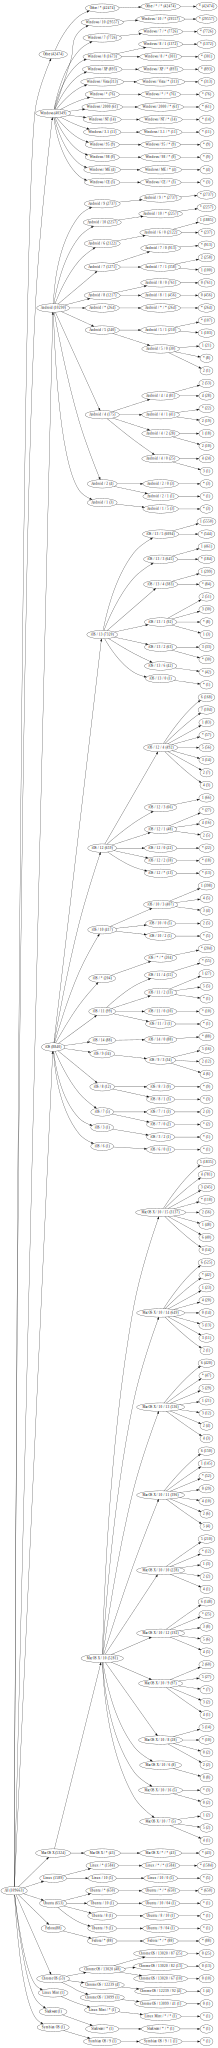

In [26]:
# usage
g = graphviz_tree(df, targets, max_children_per_node=25)
# g.render('/tmp/os_tree', cleanup=True)  # writes /tmp/os_tree.png

g

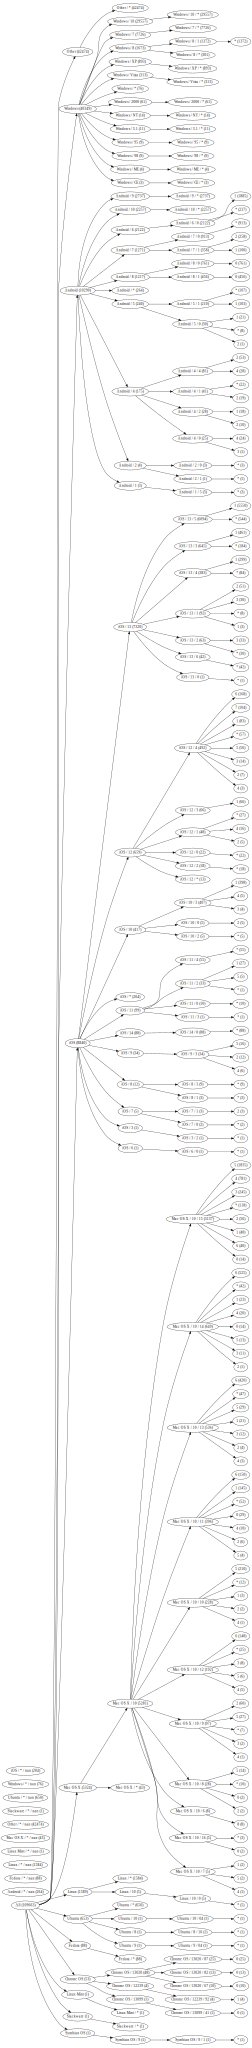

In [27]:
# usage
g = graphviz_tree_stop_unknown(df, targets, unknown_label='*', max_children_per_node=25)
# g.render('/tmp/os_tree', cleanup=True)  # writes /tmp/os_tree.png

g

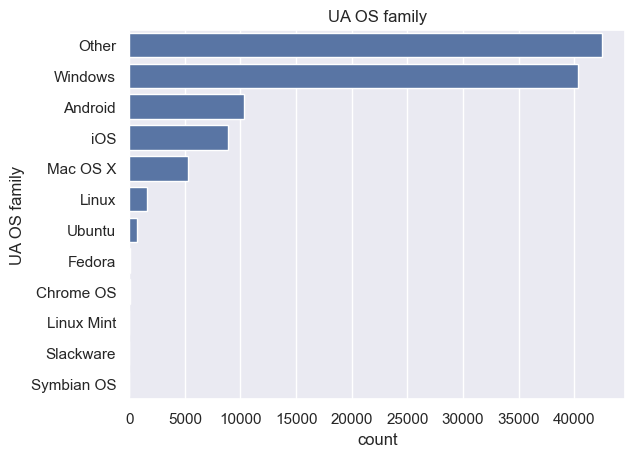

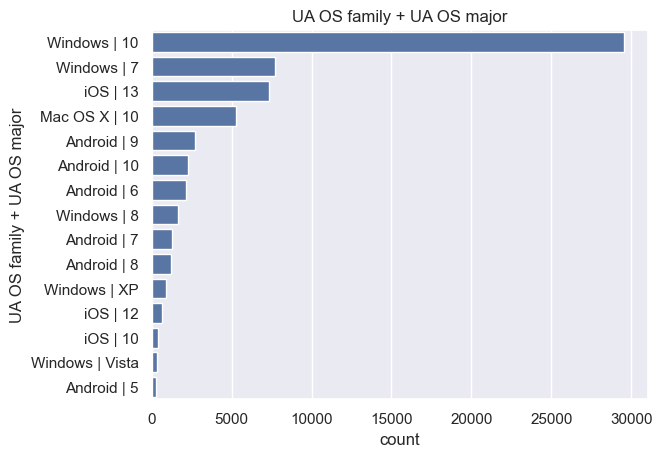

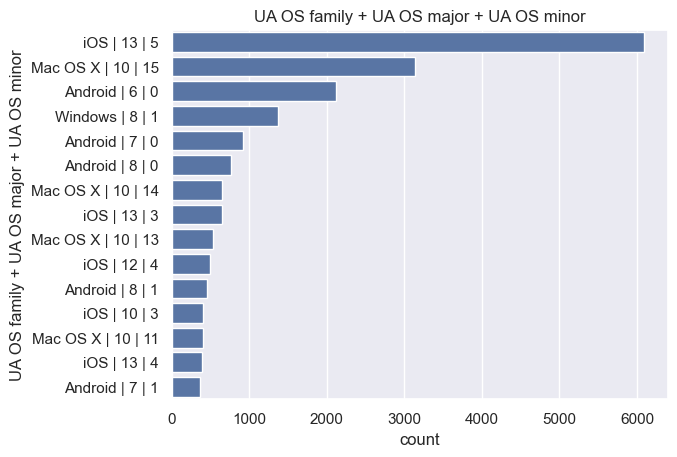

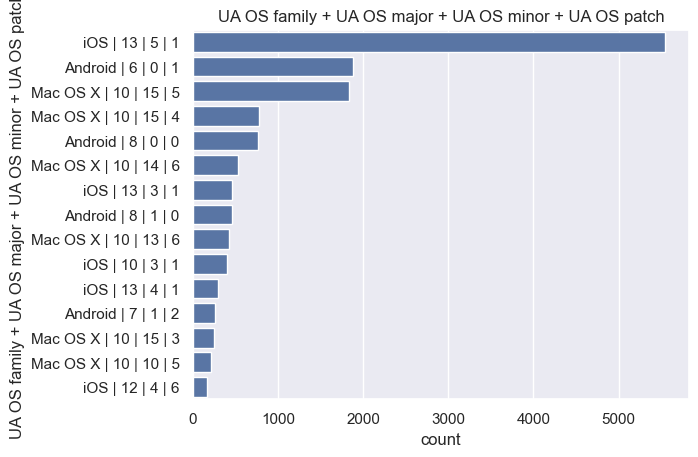

In [28]:
for i in range(1, len(targets) + 1):
    cols = targets[:i]
    col_name = " + ".join(cols)
    top = 15
    # Create a combined column for grouping
    group = df.groupby(cols).size().reset_index(name='count')
    # Get top N combinations
    top_combos = group.sort_values('count', ascending=False).head(top)
    # Filter original df to only those top combos
    mask = df[cols].apply(tuple, axis=1).isin(top_combos[cols].apply(tuple, axis=1))
    plt.xticks(rotation=0)
    sns.countplot(
        y=df.loc[mask, cols].apply(lambda row: " | ".join(map(str, row)), axis=1),
        order=top_combos[cols].apply(lambda row: " | ".join(map(str, row)), axis=1)
    )
    plt.title(col_name)
    plt.ylabel(col_name)
    plt.show()

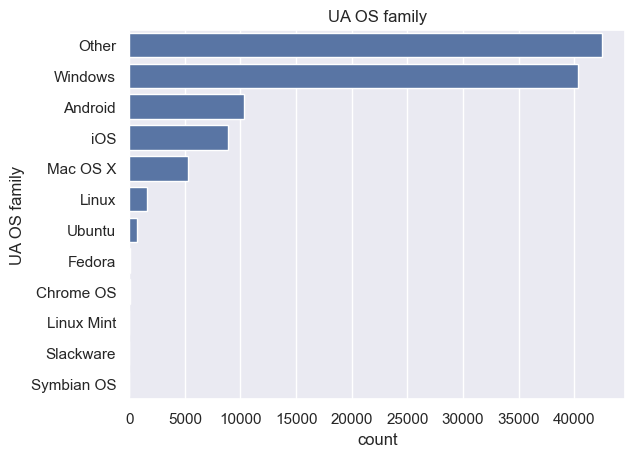

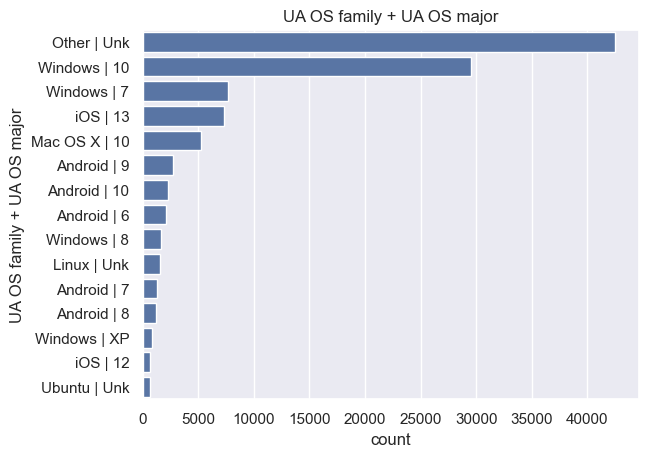

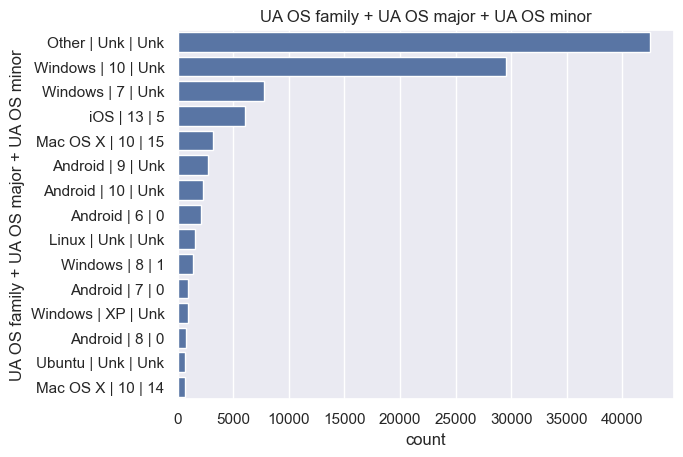

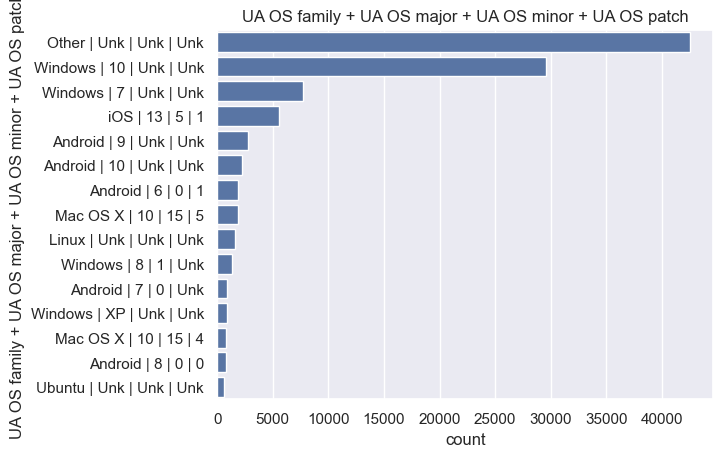

In [29]:
for i in range(1, len(targets) + 1):
    cols = targets[:i]
    col_name = " + ".join(cols)
    top = 15

    # Replace NaN with "Unk" for the relevant columns
    df_tmp = df.copy()
    df_tmp[cols] = df_tmp[cols].fillna("Unk")

    # Create a combined column for grouping
    group = df_tmp.groupby(cols).size().reset_index(name='count')
    # Get top N combinations
    top_combos = group.sort_values('count', ascending=False).head(top)
    # Filter original df to only those top combos
    mask = df_tmp[cols].apply(tuple, axis=1).isin(top_combos[cols].apply(tuple, axis=1))
    plt.xticks(rotation=0)
    sns.countplot(
        y=df_tmp.loc[mask, cols].apply(lambda row: " | ".join(map(str, row)), axis=1),
        order=top_combos[cols].apply(lambda row: " | ".join(map(str, row)), axis=1)
    )
    plt.title(col_name)
    plt.ylabel(col_name)
    plt.show()